# Building Local Gaussian Process Surrogate Models from Scratch

In this notebook, we outline how to implement local Gaussian process (LGP) surrogate models for complex experimental observables from scratch. This code can be customized to any existing experimental data / training set. LGP surrogate models are a fast and accurate machine learning model that can approximate the outputs of an expensive function (e.g. a molecular simulation) with uncertainty quantification (UQ). UQ alleviates the 'black box' nature of machine learning and allows us to directly quantify parameter, model, and predictive uncertainties. This uncertainty naturally allows us to perform on-the-fly learning, model validation, and parameter sensitivity analysis.

The code provided below is designed to be a gentle introduction to LGP surrogate models with detailed instructions on how to implement LGP surrogates for any application. We will examine a LGP surrogate model of radial distribution functions in liquid Ne (described in the paper), but constructing your own surrogate model is as simple as uploading an experimental observable and molecular simulation training set and running them through our prebuilt functions.

In [1]:
# Required Math Packages
import numpy as np
import torch as torch
from scipy import interpolate

# Plotting Packages
import matplotlib.pyplot as plt  
from matplotlib.pyplot import figure

# Parallelization
import dask
from dask.distributed import Client, progress
from dask import config as cfg

## Constructing a Training Dataset

The first step in building any supervised machine learning surrogate model is generating a training set. The training set represents "observations" from your model at many combinations of parameters. Ideally, the training set will span the parameter space of interest and be dense enough that the machine learning model can learn the patterns and relationships in the data to a high level of accuracy.  

For a single observable, $S(r_k)$, of data with many independent variables (spectra, scattering pattern, etc) the training set matrix for a local Gaussian process, $\mathbf{\hat{X'}}$, is an ($N$ $\times$ dim($\boldsymbol{\theta}$)) matrix, 

\begin{equation}\label{eq:subsurrogate_training}
    \mathbf{\hat{X'}} = 
        \begin{bmatrix}
        \theta_{1,1} & \theta_{2,1} & ...\\
        \theta_{1,2} & \theta_{2,2} & ...\\
        \vdots & \vdots & \vdots\\
        \theta_{1,N} & \theta_{2,N} & ...\\
        \end{bmatrix}
\end{equation}

where $\theta_{i,j}$ is the value of the $i^{th}$ model parameter $i = 1, ..., N_{params}$ for training sample $j = 1, ..., N$. This training set matrix is just row after row of training parameters appended together.

The training set observations, $\mathbf{\hat{Y'}}_k$, is a ($N$ $\times$ 1) column vector of the QOIs from the training set at $r_k$,

\begin{equation}
    \mathbf{\hat{Y}'}_k = [S(\boldsymbol{\theta}_1,r_k), ..., S(\boldsymbol{\theta}_N,r_k)]^T
\end{equation}

where the $k$ indexes over independent variables. Therefore, all we do is take the value of $r_k$ calculated from the training simulation and make a vector of these quantities in the same order as the training set data. 

Below, we ran 480 molecular simulations for a ($\lambda$-6) Mie fluid, which has three parameters: $\lambda$, the repulsive exponent that describes the deformability of a particle in a collision, $\sigma$ the effective collision diameter of the particle, and $\epsilon$ the dispersive attraction or "well-depth" of the potential. We used molecular dynamics (MD) to calculate a radial distribution function with 73 independent variables. For now, we choose a single independent variable to model,  which gives a training set matrix of size $(480 \times 3)$ and a training set observation vector with dimensions $(480 \times 73)$.

In [2]:
# Import the training data generated by 1_sample_gen.ipynb
rmin = 0.0118331810091873
rmax = 15.512161254882812
rnum = 73

from pickle import dump, load

input_dict = load(open('training_data/samples.p', 'rb'))
xd = input_dict['xs']

input_dict = load(open('training_data/training_rdf.p', 'rb'))
r_raw = input_dict['r']
model_rdf_raw = input_dict['model_rdf']

model_rdf = torch.zeros(len(model_rdf_raw),rnum)
r = np.linspace(rmin,rmax,rnum)

# We can interpolate this data to have the same resolution as the experiment.
for i in range(len(model_rdf_raw)):
    rdf_i = interpolate.splrep(r_raw, model_rdf_raw[i], s=0)
    model_rdf[i] = torch.from_numpy(interpolate.splev(r, rdf_i, der=0))
    
print('Training Set Matrix Shape:       '      , np.shape(xd))            # total training set
print('Training Set Observations Shape: ', np.shape(np.array(model_rdf))) # array of independent observations 

Training Set Matrix Shape:        (480, 3)
Training Set Observations Shape:  (480, 73)


## Kernels

A kernel, or covariance function, completely specifies a Gaussian process prior. The kernel is highly specific to a given problem and therefore requires careful consideration before computing Gaussian process expectations. In general, the kernel can enforce function properties like continuity and differentiability, general behavior (periodicity, positivity), and symmetry. 

In this code, we use the squared-exponential kernel because it enforces continuity and infinite differentiability. The squared-exponential kernel has the general form,

$$
    K(x, x') = \sigma^2 \exp \bigg(-\frac{(x - x')^2}{2\ell^2}\bigg)
$$

where $\sigma^2 \in \mathbb{R}$ is a scaling factor that represents the variance of the function and $\ell \in \mathbb{R}^{\text{dim}(\theta)}$ determines the length scale of fluctuations in the function. 

There are many resources available to choose the correct kernel for a given application. We recommend the Kernel Cookbook https://www.cs.toronto.edu/~duvenaud/cookbook/ or the textbook, Gaussian Processes by Rasmussen and Williams (2006). 

In [3]:
def se_kernel(x1, x2, l, width):
    """
    Computes the squared exponential kernel between the tensors x and y with hyper-parameters l and width.
    N corresponds to the number of samples and D corresponds to the number of dimensions of the input function.
    
    Parameters
    ----------
    x1: Tensor [N,D]
        Feature vector for N samples with D dimensions each
    
    x2: Tensor [N,D]
        Feature vector for N samples with D dimensions each
        
    l: Tensor [D]
        Lengthscale hyper parameter
        
    width: Float
        Width hyper parameter
        
    Returns
    ----------
    
    K: Tensor [N, N]
        Kernel matrix
        
    """
    K = width**2 * torch.exp(-(torch.cdist(x1/l,x2/l,p=2)**2)/2)
    return K

## The Local Gaussian Process Surrogate Model

The time-complexity of the training-kernel matrix inversion and the matrix product can be substantially reduced by fragmenting a standard Gaussian process into a subset of Gaussian processes along the independent variables of the target quantity-of-interest (QOI). Under this construction, an individual $GP_k$ is trained to map a set of model parameters to an individual QOI,

\begin{equation}
    \mathbb{E}[GP_k] : \boldsymbol{\theta} \mapsto S(r_k)
\end{equation}

where $\mathbf{r}$ is no longer an input parameter. The LGP surrogate model prediction for the observable at $r_k$, $S_{loc}^*(r_k)$, at a new set of parameters, $\boldsymbol{\theta}^*$, is just the expectation of the $k^{th}$ Gaussian process given the training set data,

\begin{equation}\label{eq:subsurrogate}
    S_{loc}^*(r_k) = \mathbb{E}[\textit{GP}_k(\boldsymbol{\theta}^*)] = \mathbf{K}_{\boldsymbol{\theta}^*,\mathbf{\hat{X'}}} [\mathbf{K}_{\mathbf{\hat{X'}}, \mathbf{\hat{X'}}} + \sigma_{noise}^2 \mathbf{I}]^{-1} \mathbf{\hat{Y'}}_k
\end{equation}

In the following function, we take in variables created in the training set and the hyperparameters of the kernel to create a function that calculates this expectation. If we want to call the subset of Gaussian processes at every independent input with the same $\theta^*$ we can compute,

\begin{equation}
    [S_{loc}^*(r_1),...,S_{loc}^*(r_\eta)] = \mathbf{K}_{\boldsymbol{\theta}^*,\mathbf{\hat{X'}}} [\mathbf{K}_{\mathbf{\hat{X'}}, \mathbf{\hat{X'}}} + \sigma_{noise}^2 \mathbf{I}]^{-1} \mathbf{\hat{Y'}}
\end{equation}


In [4]:
def local_surrogate(Xi, Xd, l, width, y, KddInv):
    """
    Computes the local gaussian process estimate of the structure factor given a set of pair potential parameters.
    This function assumes that the mean of y is equal to 1.  N corresponds to the number of training samples, 
    D corresponds to the number of dimensions of the input function, and M corresponds to the number of inference
    points.
    
    Parameters
    ----------
    
    Xi: Tensor [M,D]
        Feature vector for M samples with D dimensions each. This corresponds to the points you wish to infer.
    
    Xd: Tensor [N,D]
        Feature vector for N samples with D dimensions each. This corresponds to the points you trained on.
        
    l: Tensor [D]
        Lengthscale hyper parameter.
        
    width: Float
        Width hyper parameter
        
    KddInv: Tensor [N,N]
        This is the inverted kernel matrix of the training set Xd.
        
    Returns
    -------
    
    μ: Tensor [N,η]
        The mean estimate for the set of local GPs.
        
    """
    Kid = se_kernel(Xi, Xd, l, width)
    return 1 + ((Kid @ KddInv) @ (y-1))

## Hyperparameter Optimization

Choosing hyperparameters for the local GP kernel is non-trivial and requires some additional considerations. In general, changing hyperparameters can change the expectation of the local GP, so it is desirable to choose a set of hyperparameters in a systematic way. Two common methods are to (1) maximize the log-marginal likelihood (model evidence) or (2) select a set of hyperparameters that minimize the leave-one-out (LOO) error. Here we implement a brute force search for hyperparameters that minimize the LOO error. Note that the hyperparameter test ranges specified below may need to be adjusted based on your dataset and should be selected according to your expert opinion on the physics of the system.

In [5]:
def compute_loo(hyperParamOptions,j_0, j_last):

    n = len(xd)
    η = rnum
    
    Xd = torch.tensor(xd).float()
    y = torch.tensor(model_rdf).float()
    
    index = torch.arange(0,len(xd),1)
    
    looμArr = torch.zeros((j_last - j_0,480,len(r))) 
    
    for j in range(j_0,j_last,1):

        # Calculate Kdd for local GP with hyper parameter index j
        arr = hyperParamOptions[j]
        l = torch.tensor([arr[0],arr[1],arr[2]]).float()
        w = torch.tensor(arr[3]).float()
        σn = torch.tensor(arr[4]).float()
        Kdd = se_kernel(Xd,Xd,l,w) + torch.eye(len(Xd))*σn
    
        looμArr_j = torch.zeros(480,len(r))
    
        # Leave index i out from training and predict it using Local GP
        for i in range(len(xd)): 
    
            Kdd_i = Kdd[index[index != i]].T[index[index != i]].T
            KddInv_i = torch.linalg.inv(Kdd_i)
    
            # Remove the same values from y
            y_i = y[index != i]
    
            # Again for X data
            Xd_i = Xd[index[index != i]]
            Xi = Xd[i].unsqueeze(dim=0)
    
            # Compute the predictions after leaving one out
            looμ = local_surrogate(Xi,Xd_i,l,w,y_i,KddInv_i)
            looμArr_j[i] = looμ
        
        looμArr[j - j_0] = looμArr_j

    return looμArr, hyperParamOptions

In [6]:
# Creates a set of hyper parameters to compare (this may take 20-30 minutes)
trials = 5000 
hyperParamOptions = torch.zeros((trials,5))
hyperParamOptions[:,0] = (4 - 0.5) * torch.rand(trials) + 0.5
hyperParamOptions[:,1] = (1.3 - 0.01) * torch.rand(trials) + 0.01
hyperParamOptions[:,2] = (0.1 - 0.01) * torch.rand(trials) + 0.01
hyperParamOptions[:,3] = (0.08 - 0.0001) * torch.rand(trials) + 0.0001
hyperParamOptions[:,4] = (0.01 - 0.00000001) * torch.rand(trials) + 0.00000001

# Storage for the leave one out prediction of local GP
looμArr = torch.zeros((len(hyperParamOptions),480,len(r))) 

cfg.set({'distributed.scheduler.worker-ttl': None}) # This stops dask from crying when the sims take a long time.
client = Client(n_workers=20)

# Queue up function calls into dask
lazy_results = []
for i in range(int(trials/50)):
    j_0 = (i*50)
    j_last = ((i+1)*50)
    lazy_results.append(dask.delayed(compute_loo)(hyperParamOptions,j_0, j_last))

print("Queued Lazy Results")

results = dask.compute(*lazy_results)

print("Completed Calculation!")

Queued Lazy Results


/scratch/local/u1262705/8965654/ipykernel_3919998/2670912741.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/scratch/local/u1262705/8965654/ipykernel_3919998/2670912741.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/scratch/local/u1262705/8965654/ipykernel_3919998/2670912741.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Completed Calculation!


In [14]:
# Storage for the leave one out prediction of local GP
looμArr = torch.zeros((len(hyperParamOptions),480,len(r))) 

# Unfolds the dask results
for i in range(int(len(hyperParamOptions)/50)):
    j_0 = (i*50)
    j_last = ((i+1)*50)
    looμArr[j_0:j_last] = results[i][0]
    
# Compute the leave one out error for each parameter
LooErr = torch.zeros(trials)
for i in range(len(hyperParamOptions)):
    LooErr[i] = torch.sum((looμArr[i] - model_rdf)**2)
# Grab the one with the minimum error 
LooIndex = torch.argmin(LooErr)

print("Hyper parameters corresponding to the minimum leave one out error: ", hyperParamOptions[LooIndex])
print("Average error per training example per point corresponding to the minimum leave one out error: ", np.sqrt(LooErr[LooIndex].item()/len(model_rdf)/len(r)))
print()

Hyper parameters corresponding to the minimum leave one out error:  tensor([1.9327, 0.3208, 0.0632, 0.0704, 0.0043])
Average error per training example per point corresponding to the minimum leave one out error:  0.7797864430476108



## Validation with a Test Set

Now that you have specified the local Gaussian process surrogate model and found appropriate hyperparameters, you can now check whether or not the surrogate model is working properly. We evaluate the model accuracy by computing the root-mean-squared-error (RMSE) between a test set of simulation data and the LGP surrogate model. More complex metrics can be used, but RMSE is sufficent for most observables. 

In [15]:
#load in training set data
input_dict = load(open('testing_data/test_data.p', 'rb'))
totalResults = input_dict['totalResults']
totalTime = input_dict['totalTime']

# Reload Samples
input_dict = load(open('testing_data/test_samples.p', 'rb'))
xs_MAPTest = input_dict['xs']
nsampsTest = len(xs_MAPTest[:,0])
ndimsTest  = len(xs_MAPTest[0,:])

In [18]:
# Define training set data|
Xd = torch.tensor(xd).float()
y = model_rdf.float()

# Choose hyperparameters
arr = hyperParamOptions[LooIndex]
l = torch.tensor([arr[0],arr[1],arr[2]]).float()
w = torch.tensor(arr[3]).float()
σn = torch.tensor(arr[4]).float()

# Compute local GP prediction over prior predictive set
Kdd = se_kernel(Xd,Xd,l,w) + torch.eye(len(Xd))*σn
KddInv = torch.linalg.inv(Kdd)

Xi = torch.tensor(xs_MAPTest).float()
GPOut = local_surrogate(Xi, Xd, l, w, y, KddInv)

from matplotlib import cm
err = torch.zeros(160)
for i in range(160):
    err[i] = torch.sqrt(torch.sum((GPOut[i] - totalResults[i])**2)/73)

RMSE = torch.sqrt(torch.mean((GPOut - totalResults)**2,dim=0))
RMSE_total = torch.sqrt(torch.mean((GPOut - totalResults)**2))
print("RMSE Over Test Set:",float(RMSE_total))

RMSE Over Test Set: 0.03223279491066933


/scratch/local/u1262705/8965654/ipykernel_3919998/1602617338.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(arr[3]).float()
/scratch/local/u1262705/8965654/ipykernel_3919998/1602617338.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  σn = torch.tensor(arr[4]).float()


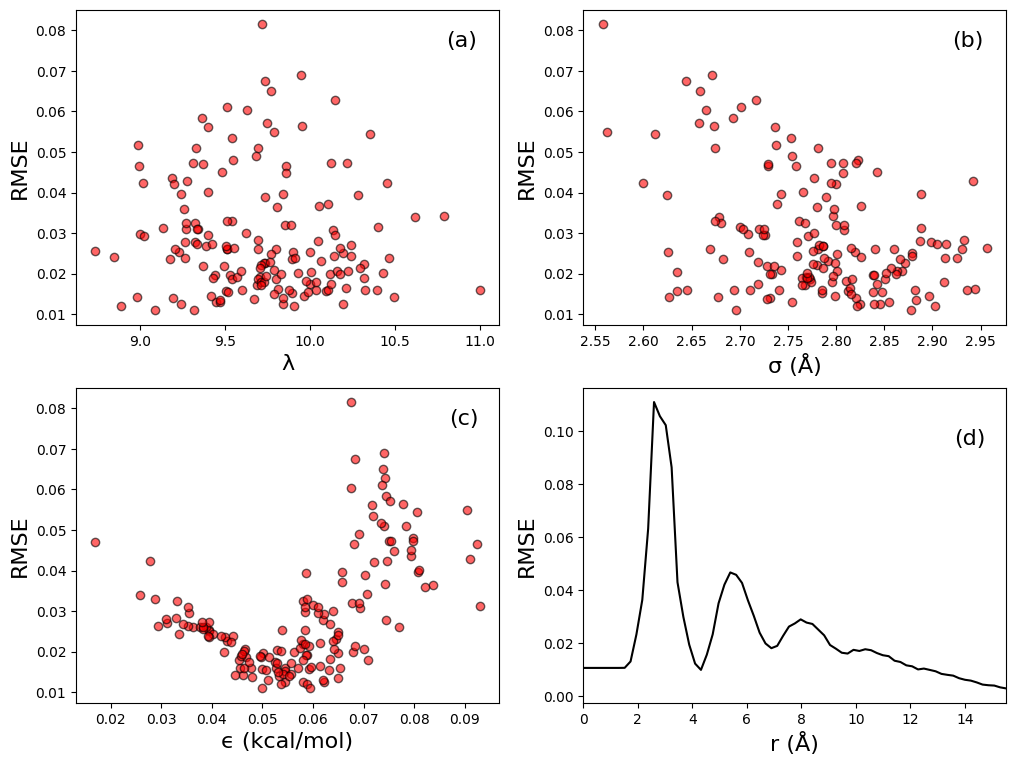

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
axs[0,0].scatter(xs_MAPTest[:,0], err, color = 'r', alpha = 0.6, edgecolors = 'k')
axs[0,0].set_xlabel('λ', fontsize = 16)
axs[0,0].set_ylabel('RMSE', fontsize = 16)
axs[0,0].text(10.8, 0.076, '(a)', fontsize = 16)
axs[0,1].scatter(xs_MAPTest[:,1], err, color = 'r', alpha = 0.6, edgecolors = 'k')
axs[0,1].set_xlabel('σ (Å)', fontsize = 16)
axs[0,1].set_ylabel('RMSE', fontsize = 16)
axs[0,1].text(2.92, 0.076, '(b)', fontsize = 16)
axs[1,0].scatter(xs_MAPTest[:,2], err, color = 'r', alpha = 0.6, edgecolors = 'k')
axs[1,0].set_xlabel('ϵ (kcal/mol)', fontsize = 16)
axs[1,0].set_ylabel('RMSE', fontsize = 16)
axs[1,0].text(0.087, 0.076, '(c)', fontsize = 16)
axs[1,1].plot(r,RMSE, color = 'k', label = 'Mean', linestyle = '-')
axs[1,1].set_xlim(0, r[-1])
axs[1,1].set_xlabel('r (Å)', fontsize = 16)
axs[1,1].set_ylabel('RMSE', fontsize = 16)
axs[1,1].text(13.6, 0.095, '(d)', fontsize = 16)
plt.show()

The RMSE is smaller than the reported uncertainty in the experimental data, so we conclude that the local GP surrogate model is sufficiently accurate to model the data.

## Concluding Remarks

Local Gaussian processes are fast and accurate surrogate models for molecular simulation applications that are especially suited for experimental data with many independent variables, such as scattering patterns or electromagnetic spectra. The methods outlined in this notebook are transferable to any data type and molecular simulation method, all that you need to do is replace the training set, test set, and experimental data with the equivalent matrices specified by your own problem. As long as these matrices are specified correctly, this notebook should be sufficient to construct an LGP surrogate model for any application in physical chemistry. 